In [181]:
%matplotlib inline

In [182]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('Set2')

In [183]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [184]:
latest_niv = get_latest_file_glob('datagov_archive/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
0 2020-12-10      0      0            0                    0          0   
1 2020-12-10      1      0            0                    0          0   
2 2020-12-10      0      0            0                    0          0   
3 2020-12-10      1      0            0                    0          0   
4 2020-12-10      0      0            0                    0          0   

  corona_result age_60_and_above gender         test_indication  
0         שלילי               No    NaN                   Other  
1         שלילי               No    NaN                  Abroad  
2         שלילי               No    NaN                   Other  
3         שלילי               No    NaN                   Other  
4         שלילי               No    NaN  Contact with confirmed

In [185]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [186]:
latest_bdi = get_latest_file_glob('datagov_archive/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [187]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [188]:
bdi.head()

test_date result_date corona_result  lab_id  test_for_corona_diagnosis  \
0 2020-08-09  2020-08-09         שלילי       2                          1   
1 2020-08-09  2020-08-09         חיובי       2                          1   
2 2020-08-10  2020-08-10         שלילי       2                          1   
3 2020-03-11  2020-03-11         שלילי      32                          1   
4 2020-03-11  2020-03-11         שלילי      32                          1   

  is_first_Test orig_test_date  
0           Yes            NaT  
1            No            NaT  
2           Yes            NaT  
3           Yes     2020-03-11  
4           Yes     2020-03-11

In [189]:
bdi.shape

(6644376, 7)

In [190]:
niv.corona_result.value_counts()

שלילי    2962584
חיובי     236195
אחר        57263
Name: corona_result, dtype: int64

In [191]:
bdi.corona_result.value_counts()

שלילי                 6034760
חיובי                  425113
חיובי גבולי             61218
לא בוצע/פסול 999        60045
לא בוצע – איגום         30848
שלילי סופיה             28203
חיובי באיגום             1687
בעבודה                   1160
חיובי גבולי באיגום        937
לא ודאי ישן               397
חיובי סופיה                 8
Name: corona_result, dtype: int64

In [192]:
niv.corona_result.value_counts()

שלילי    2962584
חיובי     236195
אחר        57263
Name: corona_result, dtype: int64

In [193]:
niv.test_indication.value_counts()

Other                     3035772
Contact with confirmed     196755
Abroad                      23515
Name: test_indication, dtype: int64

In [194]:
niv.age_60_and_above.value_counts()

No     2371665
Yes     371713
Name: age_60_and_above, dtype: int64

In [195]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [196]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
    'שלילי סופיה': 'negative',
    'חיובי סופיה': 'positive',
    'חיובי גבולי': 'boderline',
    'לא בוצע – איגום': 'not_done',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [197]:
bdi_result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'חיובי גבולי': 'borderline',
    'לא בוצע/פסול 999': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
    'לא ודאי ישן': 'uncertain',
    'אחר': 'other',
    'חיובי באיגום': 'positive_igum',
    'חיובי גבולי באיגום': 'positive_igum',
}
bdi['corona_result'] = bdi.corona_result.map(bdi_result_map)

In [198]:
bdi.corona_result.value_counts()

negative         6034760
positive          425113
borderline         61218
not_done           60045
positive_igum       2624
in_progress         1160
uncertain            397
Name: corona_result, dtype: int64

In [199]:
rec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

In [200]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

total_tests_count   size  min  max       mean  median  test_sum
0                  2      6    6   17  12.833333      13        12
1                  3  11061    2  112  16.665582      17     33183
2                  4   5081    2  114  21.462114      21     20324
3                  5   3127    2  106  24.647905      25     15635
4                  6   1786    6   96  27.668533      27     10716
5                  7   1063    8  108  30.398871      30      7441
6                  8    597    3  103  33.475712      33      4776
7                  9    357    3   78  35.700280      35      3213
8                 10    573    5  106  41.130890      41      5730

In [201]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

index  total_tests_count
0    size       23651.000000
1     min           2.000000
2     max          12.000000
3    mean           4.320156
4  median           4.000000

In [202]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


days_between_pos_and_neg total_tests_count age_group gender  \
9432                        114                 4       60+    זכר   
12342                       112                 3     30-39    זכר   
9304                        111                 4     20-29    זכר   
1600                        108                 7     40-49   נקבה   
6311                        106                 5     30-39    זכר   
23175                       106               10+      0-19   נקבה   
9696                        105                 4     30-39   נקבה   
456                         103                 8     50-59   נקבה   
20936                       103                 3      0-19    זכר   
23273                       100               10+       60+    זכר   

              test_indication  
9432                    Other  
12342  Contact with confirmed  
9304                    Other  
1600   Contact with confirmed  
6311   Contact with confirmed  
23175  Contact with confirmed  
9696                    Other  
456    Contact with confirmed  
20936                  Abroad  
23273  Contact with confirmed

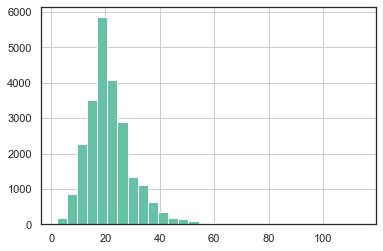

In [203]:
rec.days_between_pos_and_neg.hist(bins=30)

In [204]:
iso = pd.read_csv(get_latest_file_glob('datagov_archive/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

date  isolated_today_contact_with_confirmed  isolated_today_abroad  \
0  2020-12-09                                  69712                  24877   
1  2020-12-08                                  65618                  25492   
2  2020-12-07                                  65290                  27601   
3  2020-12-06                                  61213                  27609   
4  2020-12-05                                  54804                  26296   

  new_contact_with_confirmed new_from_abroad  
0                      10604            1325  
1                      10508            1401  
2                       8683            2084  
3                       9898            2605  
4                       4825            1137

In [205]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [206]:
niv.age_60_and_above.value_counts()

No     2371665
Yes     371713
Name: age_60_and_above, dtype: int64

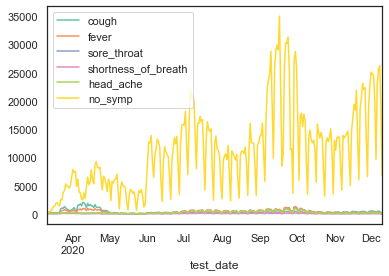

In [207]:
niv.groupby('test_date')[symptom_cols].sum().plot()

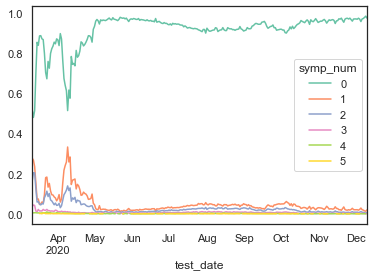

In [208]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

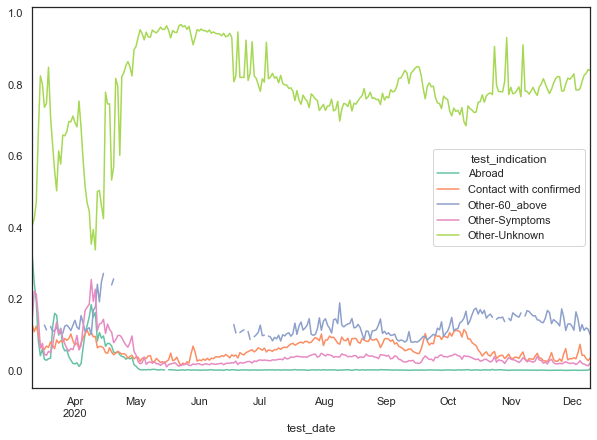

In [209]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

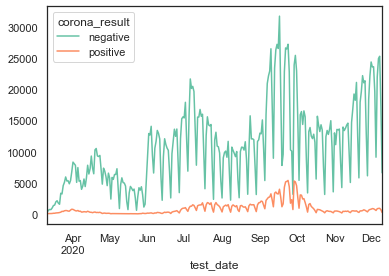

In [210]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [211]:
bdi.dtypes

test_date                    datetime64[ns]
result_date                  datetime64[ns]
corona_result                        object
lab_id                                int64
test_for_corona_diagnosis             int64
is_first_Test                        object
orig_test_date               datetime64[ns]
dtype: object

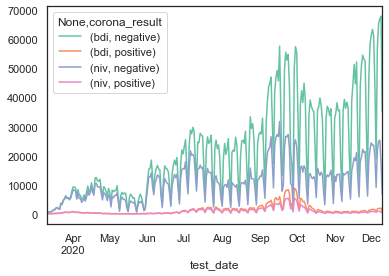

In [212]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

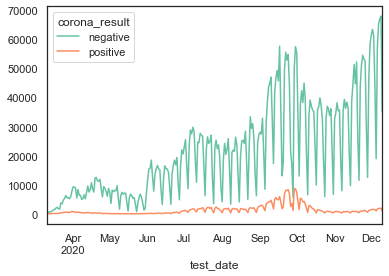

In [213]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [214]:
pone = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'corona_result']].fillna('Other').groupby(['test_date', 'corona_result'], sort=False).size().unstack()
pone[pone.positive>20]

corona_result  negative  positive  uncertain  in_progress  not_done  \
test_date                                                             
2020-08-09      21219.0    1613.0        NaN          1.0      77.0   
2020-08-10      21918.0    1859.0        NaN          1.0     112.0   
2020-03-12        615.0      31.0        NaN          2.0       1.0   
2020-03-25       5304.0     502.0       49.0         21.0      42.0   
2020-03-13        721.0      33.0        NaN          NaN       NaN   
...                 ...       ...        ...          ...       ...   
2020-12-06      56941.0    1646.0        NaN          6.0     207.0   
2020-12-07      65428.0    1883.0        NaN          7.0     503.0   
2020-12-08      67089.0    1860.0        NaN         17.0     321.0   
2020-12-04      43809.0    1386.0        NaN          3.0     229.0   
2020-12-10      35010.0     891.0        NaN          NaN     313.0   

corona_result  borderline   Other  positive_igum  
test_date                                         
2020-08-09           94.0     NaN            NaN  
2020-08-10          162.0     NaN            NaN  
2020-03-12            NaN     NaN            NaN  
2020-03-25            NaN     NaN            NaN  
2020-03-13            NaN     NaN            NaN  
...                   ...     ...            ...  
2020-12-06          164.0  2356.0            NaN  
2020-12-07          212.0  1632.0            9.0  
2020-12-08          232.0  2137.0            NaN  
2020-12-04          181.0  1171.0            NaN  
2020-12-10          104.0  2104.0            NaN  

[264 rows x 8 columns]

In [215]:
pone.tail(5)

corona_result  negative  positive  uncertain  in_progress  not_done  \
test_date                                                             
2020-12-06      56941.0    1646.0        NaN          6.0     207.0   
2020-12-07      65428.0    1883.0        NaN          7.0     503.0   
2020-12-08      67089.0    1860.0        NaN         17.0     321.0   
2020-12-04      43809.0    1386.0        NaN          3.0     229.0   
2020-12-10      35010.0     891.0        NaN          NaN     313.0   

corona_result  borderline   Other  positive_igum  
test_date                                         
2020-12-06          164.0  2356.0            NaN  
2020-12-07          212.0  1632.0            9.0  
2020-12-08          232.0  2137.0            NaN  
2020-12-04          181.0  1171.0            NaN  
2020-12-10          104.0  2104.0            NaN

In [216]:
niv.shape

(3256042, 12)

In [217]:
bdi[bdi.is_first_Test=='Yes'].shape

(3032924, 7)

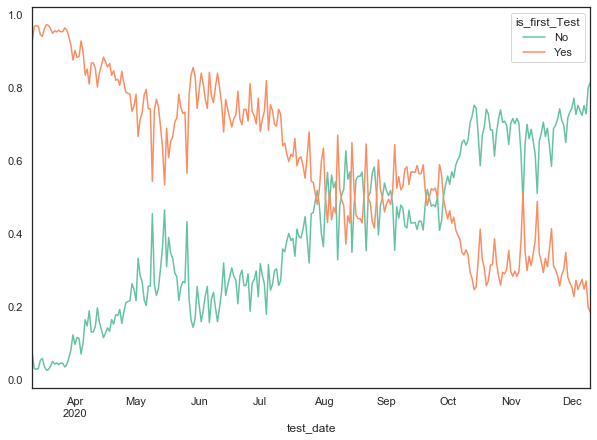

In [218]:
ti = bdi[(bdi.test_date>'2020') 
         & (bdi.test_date<'2021') 
         & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

In [219]:
(ti.div(ti.sum(axis=1), axis=0))

is_first_Test        No       Yes
test_date                        
2020-03-11     0.073446  0.926554
2020-03-12     0.030817  0.969183
2020-03-13     0.029178  0.970822
2020-03-14     0.030464  0.969536
2020-03-15     0.053219  0.946781
...                 ...       ...
2020-12-06     0.724755  0.275245
2020-12-07     0.751715  0.248285
2020-12-08     0.729206  0.270794
2020-12-09     0.800834  0.199166
2020-12-10     0.814429  0.185571

[275 rows x 2 columns]

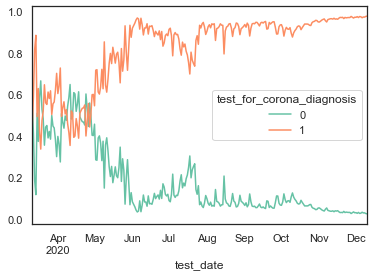

In [220]:
ti = bdi[(bdi.is_first_Test=='No')].groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

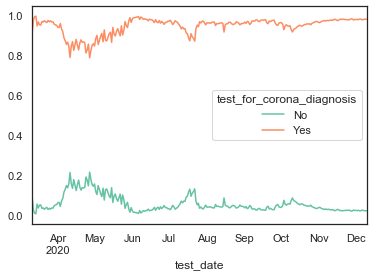

In [221]:
ti = bdi.groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
ti = ti.rename(columns={0: 'No', 1: 'Yes'})
(ti.div(ti.sum(axis=1), axis=0)).plot()

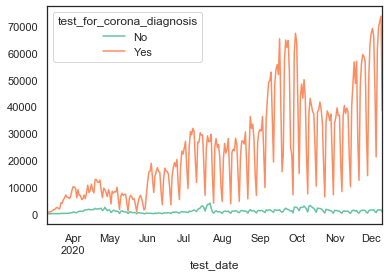

In [222]:
ti.plot()

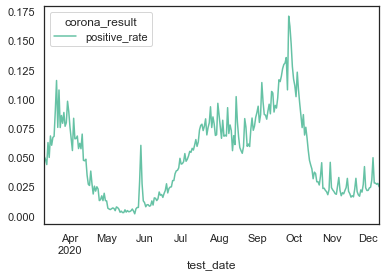

In [223]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain))[['positive_rate']]
 .plot())

In [224]:
import altair as alt

In [225]:
ti.tail()

test_for_corona_diagnosis    No    Yes
test_date                             
2020-12-06                 1404  61320
2020-12-07                 1465  69674
2020-12-08                 1484  71656
2020-12-09                 1468  73642
2020-12-10                  735  38422

In [226]:
ti.Yes.sum() + ti.No.sum()

6644363

In [227]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [228]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [229]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [230]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')
          ]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [231]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [232]:
get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')

'datagov_archive\\corona_hospitalization_ver_00166_20201213211116.xlsx.gz'

In [233]:
import gzip
hos = (pd.read_excel(gzip.open(get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')))
       .fillna('<15')
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.tail()

date  מאושפזים  אחוז נשים מאושפזות  גיל ממוצע מאושפזים  \
270 2020-12-06       634                44.6                  65   
271 2020-12-07       623                42.9                  65   
272 2020-12-08       609                41.9                  65   
273 2020-12-09       621                40.7                  64   
274 2020-12-10       666                42.0                  64   

     סטיית תקן גיל מאושפזים  resp  אחוז נשים מונשמות  גיל ממוצע מונשמים  \
270                    18.8    85               41.2                 68   
271                    18.0    83               38.6                 68   
272                    18.1    91               39.6                 68   
273                    18.8    93               36.6                 67   
274                    18.4    96               35.4                 67   

     סטיית תקן גיל מונשמים  חולים קל  ...  סטיית תקן גיל חולים קל  medium  \
270                   13.2       206  ...                    23.8      89   
271                   11.8       189  ...                    22.7     105   
272                   12.2       170  ...                    23.2     117   
273                   12.6       185  ...                    23.9     118   
274                   11.9       197  ...                    24.0     137   

     אחוז נשים חולות בינוני  גיל ממוצע חולים בינוני  \
270                    51.7                      65   
271                    47.6                      65   
272                    45.3                      64   
273                    44.9                      64   
274                    43.8                      65   

    סטיית תקן גיל חולים בינוני critical אחוז נשים חולות קשה  \
270                       16.4      339                38.3   
271                       16.4      329                37.7   
272                       17.3      322                37.6   
273                       17.7      318                36.2   
274                       15.3      332                35.2   

     גיל ממוצע חולים קשה  סטיית תקן גיל חולים קשה  חולים קשה מצטבר  
270                   68                     14.9             7862  
271                   68                     14.5             7896  
272                   68                     14.4             7924  
273                   68                     14.3             7958  
274                   68                     14.1             7992  

[5 rows x 22 columns]

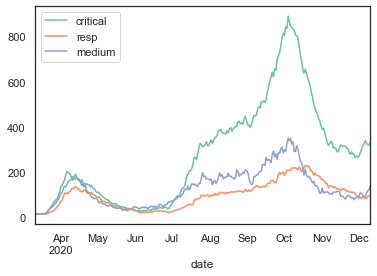

In [234]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [235]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


test_date  critical  resp  medium  borderline  in_progress  negative  \
0 2020-03-11        15    15      15         0.0         18.0     324.0   
1 2020-03-12        15    15      15         0.0          2.0     616.0   
2 2020-03-13        15    15      15         0.0          0.0     721.0   
3 2020-03-14        15    15      15         0.0          3.0     704.0   
4 2020-03-15        15    15      15         0.0         93.0    1025.0   

   not_done  positive  positive_igum  uncertain  positive_rate  
0       0.0      45.0            0.0        1.0       0.121622  
1       1.0      45.0            0.0        0.0       0.068079  
2       0.0      38.0            0.0        0.0       0.050066  
3       1.0      50.0            0.0        0.0       0.066313  
4       9.0     103.0            0.0        0.0       0.091312

In [236]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [237]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


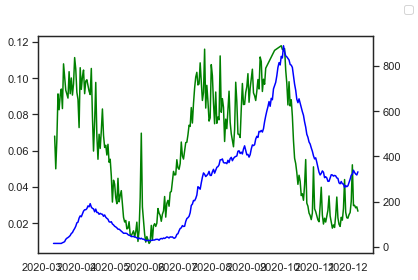

In [238]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [239]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [240]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [241]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

In [242]:
polab = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'lab_id', 'corona_result']].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative+polab.borderline+polab.uncertain)

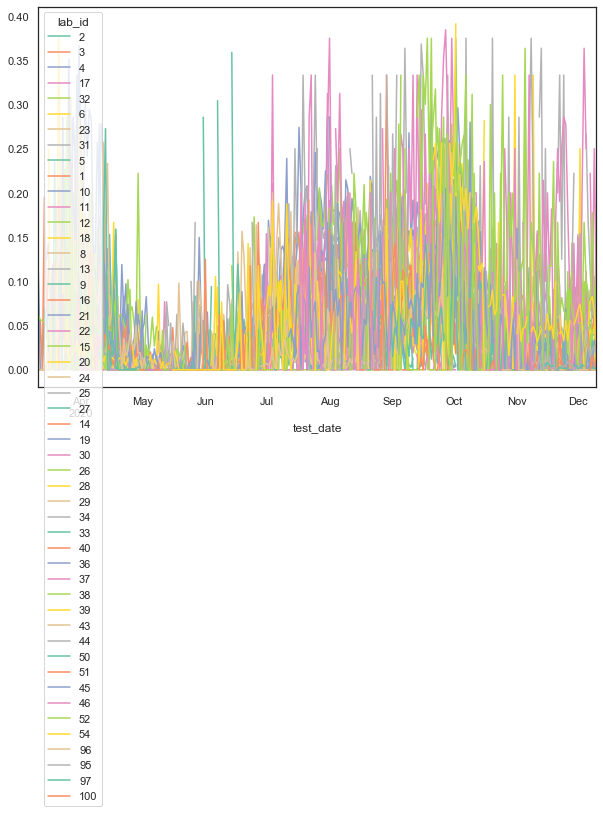

In [243]:
polab[polab.positive_rate<0.4].positive_rate.unstack().plot(figsize=(10,7))

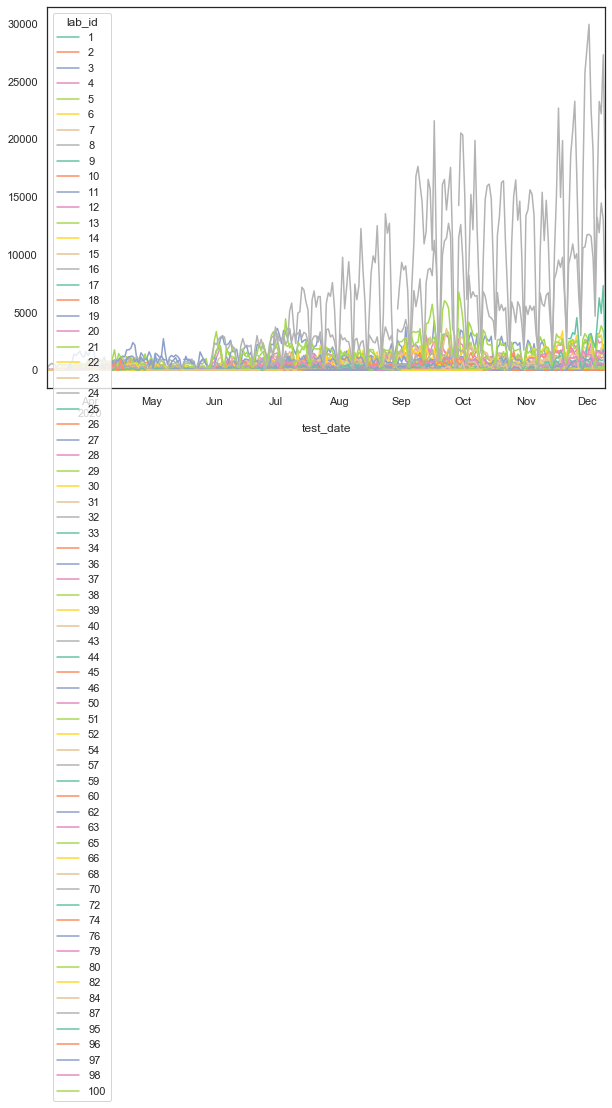

In [244]:
polab.total_tests.unstack().plot(figsize=(10,7))

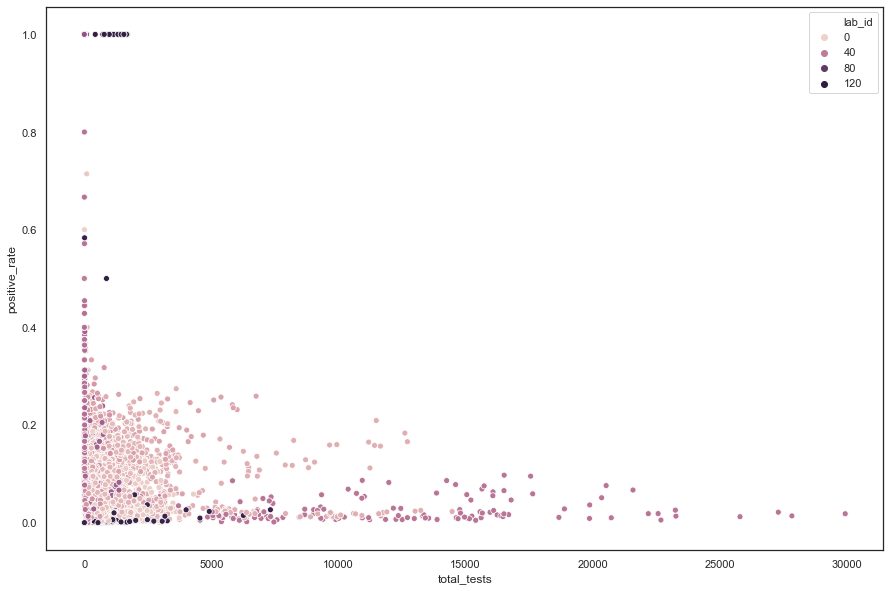

In [245]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [246]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [247]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [248]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result  positive   negative  total_tests  positive_rate
lab_id                                                        
43              44634.0  1556692.0    1655431.0            1.4
16              66580.0   859827.0     931862.0            3.9
3               11207.0   382549.0     396172.0            1.5
21              48367.0   341088.0     394686.0            7.1
13              27500.0   309452.0     343897.0            4.4
...                 ...        ...          ...            ...
87                  0.0        0.0         25.0            NaN
63                  0.0        0.0         21.0            NaN
72                  0.0        0.0         20.0            NaN
65                  8.0        0.0         19.0            inf
7                  18.0        0.0         18.0            inf

[69 rows x 4 columns]

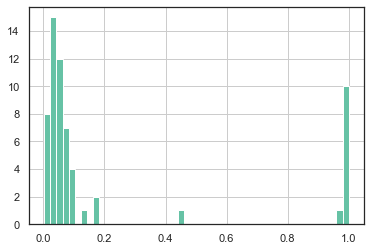

In [249]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [250]:
top_5_labs = bdi[(bdi.test_for_corona_diagnosis==1)].lab_id.value_counts().index[:10]
top_5_labs

Int64Index([43, 16, 3, 21, 13, 4, 10, 15, 14, 12], dtype='int64')

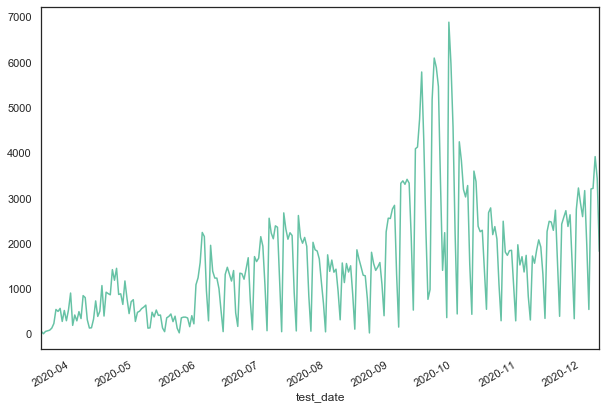

In [251]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

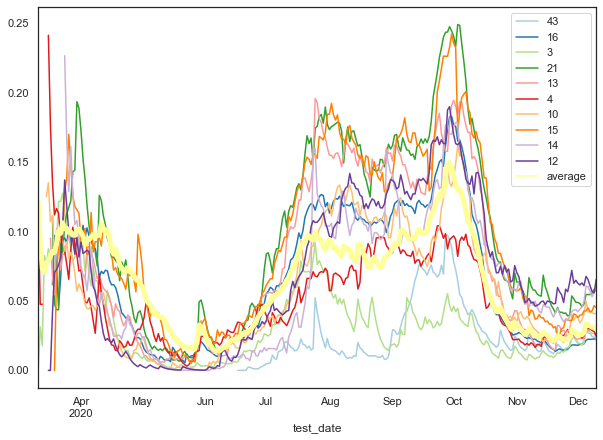

In [252]:
sns.set_palette(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


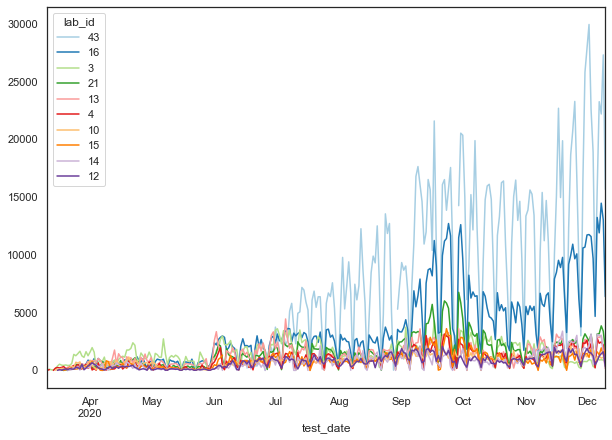

In [253]:
forp = polab.total_tests.unstack()[top_5_labs]
ax = forp.plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


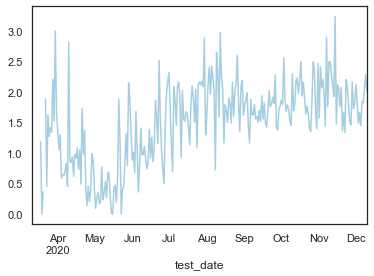

In [254]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [255]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06170060213329288

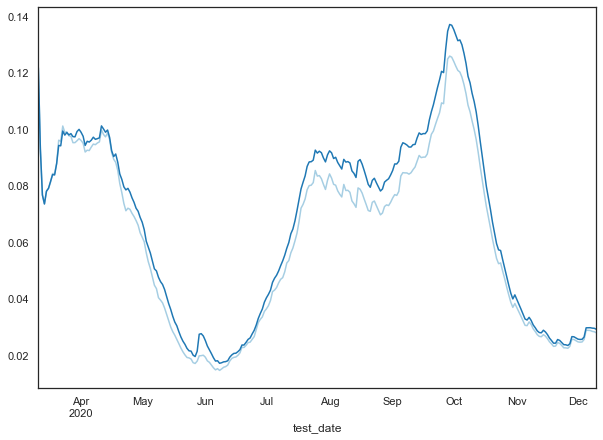

In [256]:
ax = (bdi[~(bdi.lab_id.isin([13,21]))].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

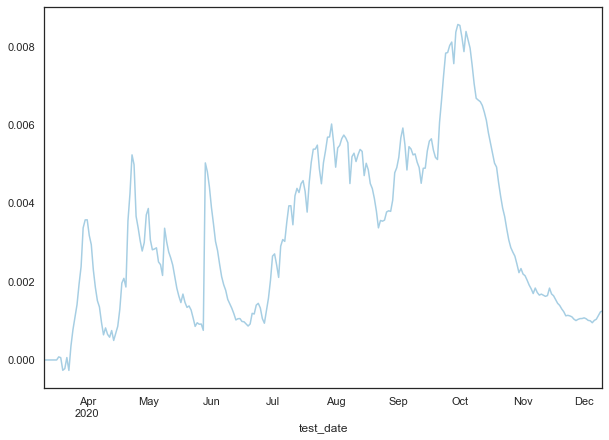

In [257]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

In [258]:
alt.Chart(polab[polab.total_tests>100].reset_index()).mark_point(size=2).encode(
    x='test_date',
    y='total_tests',
    color='positive_rate:Q',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [259]:
xx = (polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1))
 .assign(positive_rq = lambda x: pd.qcut(x.positive_rate, 5))
)
xx

corona_result  positive   negative  total_tests  positive_rate   positive_rq
lab_id                                                                      
43              44634.0  1556692.0    1655431.0            1.4  (0.099, 1.6]
16              66580.0   859827.0     931862.0            3.9    (2.5, 4.0]
3               11207.0   382549.0     396172.0            1.5  (0.099, 1.6]
21              48367.0   341088.0     394686.0            7.1   (4.0, 10.4]
13              27500.0   309452.0     343897.0            4.4   (4.0, 10.4]
...                 ...        ...          ...            ...           ...
87                  0.0        0.0         25.0            NaN           NaN
63                  0.0        0.0         21.0            NaN           NaN
72                  0.0        0.0         20.0            NaN           NaN
65                  8.0        0.0         19.0            inf   (10.4, inf]
7                  18.0        0.0         18.0            inf   (10.4, inf]

[69 rows x 5 columns]

In [260]:
polab = polab.reset_index()
polab['total_pr'] = polab.lab_id.map(xx.positive_rate)
polab['total_prq'] = polab.lab_id.map(xx.positive_rq)
polab = polab.set_index(['test_date', 'lab_id'])
polab.head()

corona_result      Other  borderline  in_progress  negative  not_done  \
test_date  lab_id                                                       
2020-03-11 1         0.0         0.0          0.0       0.0       0.0   
           2         0.0         0.0          0.0      70.0       0.0   
           3         0.0         0.0          1.0      36.0       0.0   
           4         0.0         0.0          0.0      16.0       0.0   
           6         0.0         0.0         16.0       0.0       0.0   

corona_result      positive  positive_igum  uncertain  total_tests  \
test_date  lab_id                                                    
2020-03-11 1            2.0            0.0        0.0          2.0   
           2            0.0            0.0        0.0         70.0   
           3            0.0            0.0        1.0         38.0   
           4            2.0            0.0        0.0         18.0   
           6            0.0            0.0        0.0         16.0   

corona_result      positive_rate  total_pr     total_prq  
test_date  lab_id                                         
2020-03-11 1            1.000000      27.4   (10.4, inf]  
           2            0.000000       1.7    (1.6, 2.5]  
           3            0.000000       1.5  (0.099, 1.6]  
           4            0.111111       2.9    (2.5, 4.0]  
           6                 NaN       1.2  (0.099, 1.6]

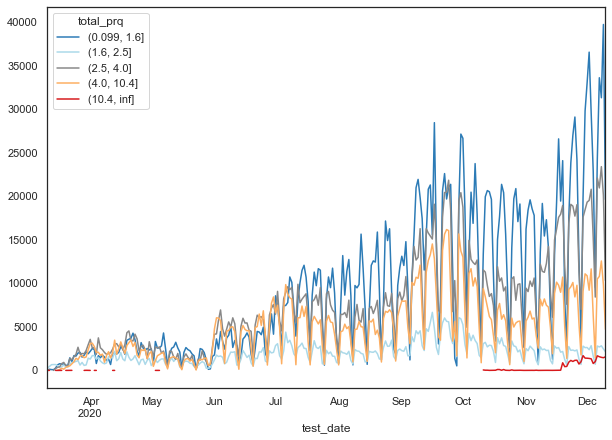

In [261]:
sns.set_palette(['#d7191c','#fdae61','#888888','#abd9e9','#2c7bb6'][::-1])
#sns.set_palette(['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])
sns.set_style('white')
prq = (polab.reset_index()
 .groupby(['test_date', 'total_prq']).total_tests.sum()
 .unstack()
)
prq.plot(figsize=(10,7))

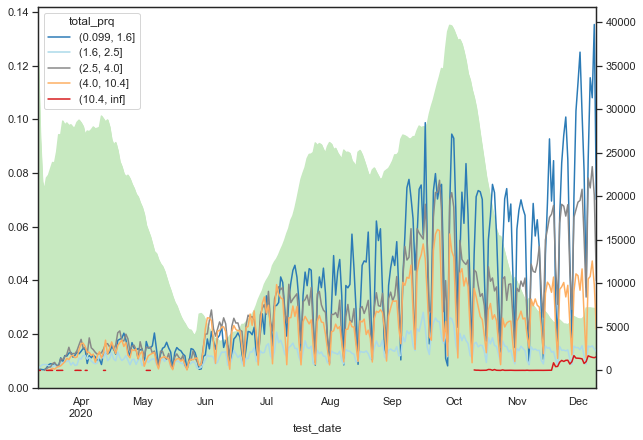

In [262]:
ax=(bdi.groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
    .assign(pr = lambda x: x.positive/(x.negative+x.positive+x.borderline+x.uncertain))
   ).pr.ewm(7).mean().plot(color='#c7e9c0', kind='area', figsize=(10,7))
ax2=ax.twinx()
prq.plot(ax=ax2)

## Decseased 

In [263]:
last_dec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_deceased_ver*.csv.gz'), 
                       encoding='1255', low_memory=False, compression='gzip')
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11, duplicates='drop')
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 2.0]    0.186331
(2.0, 5.0]       0.117647
(5.0, 7.0]       0.096906
(7.0, 9.0]       0.080585
(9.0, 11.0]      0.076165
(11.0, 14.0]     0.084665
(14.0, 18.0]     0.092826
(18.0, 23.0]     0.087385
(23.0, 33.0]     0.082285
(33.0, 209.0]    0.089765
Name: qc, dtype: float64

In [264]:
sns.set_palette('Set2')


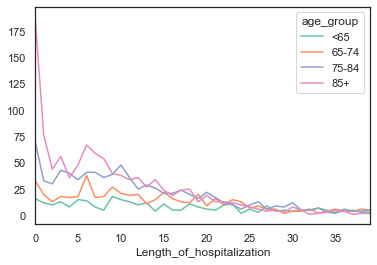

In [265]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

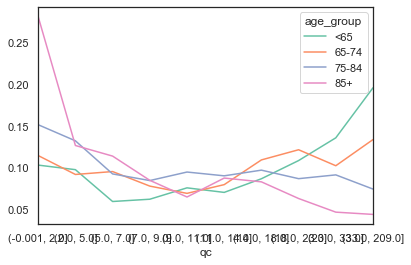

In [266]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [267]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.105066
1.0    0.048283
2.0    0.032982
3.0    0.044203
4.0    0.034342
5.0    0.039102
6.0    0.054403
7.0    0.042503
8.0    0.038422
9.0    0.042163
Name: Length_of_hospitalization, dtype: float64

In [268]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-203.0    0.00034
-141.0    0.00034
-120.0    0.00034
-63.0     0.00034
-52.0     0.00034
-44.0     0.00034
-36.0     0.00034
-35.0     0.00068
-34.0     0.00034
-31.0     0.00068
Name: Time_between_positive_and_hospitalization, dtype: float64

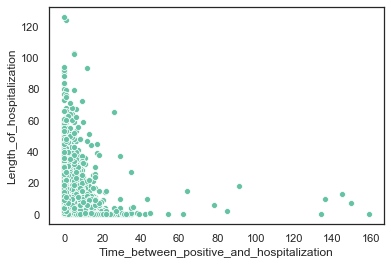

In [269]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

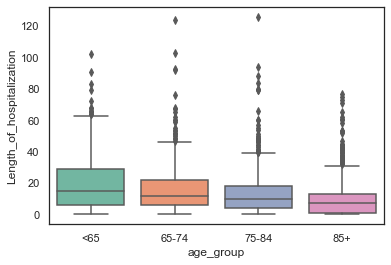

In [270]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [271]:
decs = []
for file in sorted(glob.glob('datagov_archive/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    for enc in ['1255', 'utf-8-sig']:
        try:
            dec = pd.read_csv(file, 
                  encoding=enc, low_memory=False)
        except:
            continue
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

gender age_group  Ventilated  Time_between_positive_and_hospitalization  \
0      זכר       <65         1.0                                        2.0   
203   נקבה     75-84         1.0                                        0.0   
202   נקבה       85+         0.0                                       10.0   
201   נקבה       85+         0.0                                        2.0   
200    זכר       85+         1.0                                        0.0   

     Length_of_hospitalization  Time_between_positive_and_death  \
0                         20.0                             22.0   
203                       12.0                             12.0   
202                        1.0                             11.0   
201                       17.0                             19.0   
200                        9.0                              9.0   

                   time                                            file  
0   2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
203 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
202 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
201 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
200 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz

In [272]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((72339, 8), (2401, 8))

In [273]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

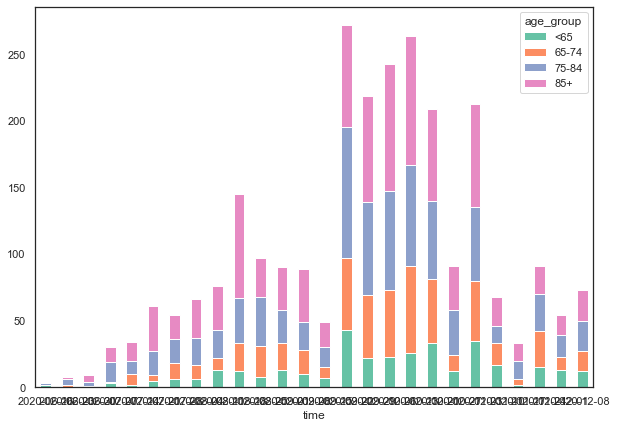

In [274]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

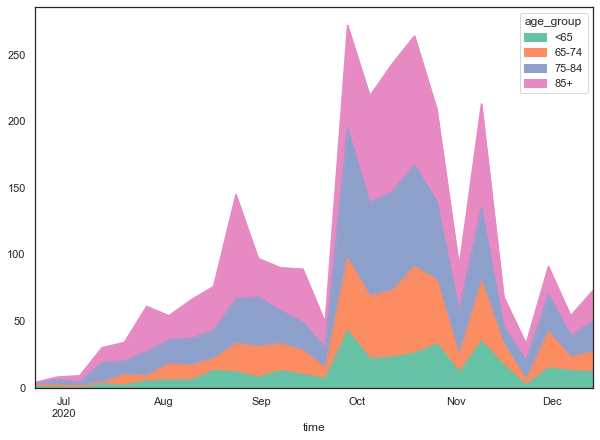

In [275]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

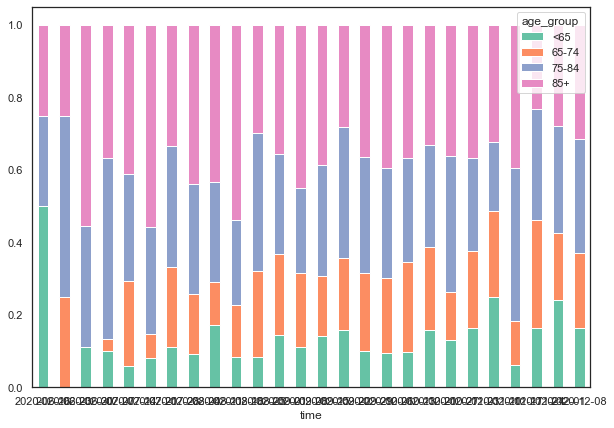

In [276]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [277]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


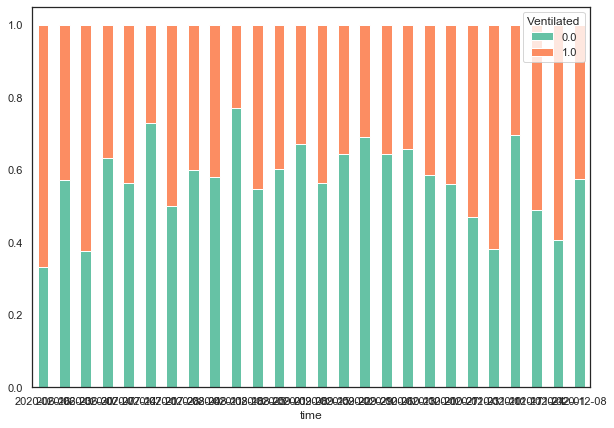

In [278]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

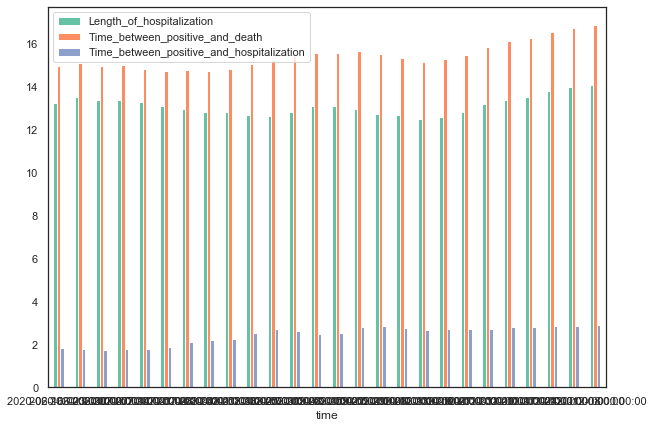

In [279]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


In [280]:
hos.head().T

0                    1  \
date                        2020-03-11 00:00:00  2020-03-12 00:00:00   
מאושפזים                                     79                  102   
אחוז נשים מאושפזות                         36.7                 40.2   
גיל ממוצע מאושפזים                           48                   50   
סטיית תקן גיל מאושפזים                     17.9                 18.1   
resp                                         15                   15   
אחוז נשים מונשמות                            20                   20   
גיל ממוצע מונשמים                            64                   64   
סטיית תקן גיל מונשמים                        15                   15   
חולים קל                                     72                   95   
אחוז נשים חולות קל                         37.5                 41.1   
גיל ממוצע חולים קל                           47                   49   
סטיית תקן גיל חולים קל                     17.4                 17.8   
medium                                       15                   15   
אחוז נשים חולות בינוני                      <15                  <15   
גיל ממוצע חולים בינוני                      <15                  <15   
סטיית תקן גיל חולים בינוני                  <15                  <15   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                 33.3   
גיל ממוצע חולים קשה                          67                   67   
סטיית תקן גיל חולים קשה                    15.8                 15.8   
חולים קשה מצטבר                             <15                  <15   

                                              2                    3  \
date                        2020-03-13 00:00:00  2020-03-14 00:00:00   
מאושפזים                                    120                  158   
אחוז נשים מאושפזות                         39.2                 41.1   
גיל ממוצע מאושפזים                           50                   48   
סטיית תקן גיל מאושפזים                     18.2                 18.4   
resp                                         15                   15   
אחוז נשים מונשמות                            20                    0   
גיל ממוצע מונשמים                            64                   70   
סטיית תקן גיל מונשמים                        15                  6.8   
חולים קל                                    109                  148   
אחוז נשים חולות קל                         39.4                 41.9   
גיל ממוצע חולים קל                           48                   46   
סטיית תקן גיל חולים קל                     17.5                 17.5   
medium                                       15                   15   
אחוז נשים חולות בינוני                       40                   40   
גיל ממוצע חולים בינוני                       68                   68   
סטיית תקן גיל חולים בינוני                 17.1                 17.1   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                   20   
גיל ממוצע חולים קשה                          67                   77   
סטיית תקן גיל חולים קשה                    15.8                   10   
חולים קשה מצטבר                             <15                  <15   

                                              4  
date                        2020-03-15 00:00:00  
מאושפזים                                    197  
אחוז נשים מאושפזות                         44.2  
גיל ממוצע מאושפזים                           47  
סטיית תקן גיל מאושפזים                     18.7  
resp                                         15  
אחוז נשים מונשמות                            20  
גיל ממוצע מונשמים                            74  
סטיית תקן גיל מונשמים                       7.3  
חולים קל                                    182  
אחוז נשים חולות קל                         44.5  
גיל ממוצע חולים קל                           45  
סטיית תקן גיל חולים קל                     17.5  
medium                          

In [281]:
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

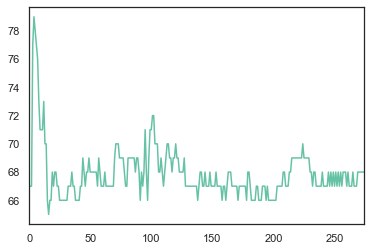

In [282]:
hos['גיל ממוצע חולים קשה'].plot()

## Recovered

In [283]:
pd.read_csv('datagov_archive/corona_recovered_ver_004.csv.gz', encoding='1255')

days_between_pos_and_neg total_tests_count age_group gender  \
0                          8.0                 9     40-49   נקבה   
1                         19.0                 9     30-39    זכר   
2                         33.0                 9       60+    זכר   
3                         24.0                 9     30-39    זכר   
4                         20.0                 9     40-49    זכר   
...                        ...               ...       ...    ...   
6408                       NaN               NaN       60+    זכר   
6409                       NaN               NaN       60+   נקבה   
6410                       NaN               NaN       60+   נקבה   
6411                       NaN               NaN       60+    זכר   
6412                       NaN               NaN       60+    זכר   

             test_indication  
0     Contact with confirmed  
1     Contact with confirmed  
2                     Abroad  
3     Contact with confirmed  
4                     Abroad  
...                      ...  
6408                   Other  
6409  Contact with confirmed  
6410  Contact with confirmed  
6411                  Abroad  
6412                  Abroad  

[6413 rows x 5 columns]

In [284]:
recs = []
for file in sorted(glob.glob('datagov_archive/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

datagov_archive\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
datagov_archive\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
datagov_archive\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
datagov_archive\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
datagov_archive\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
datagov_archive\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
datagov_archive\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
datagov_archive\corona_recovered_ver_00

days_between_pos_and_neg total_tests_count age_group gender  \
4923                      12.0                 3     30-39   נקבה   
4281                      15.0                 3     40-49   נקבה   
4280                       4.0                 3     20-29   נקבה   
4279                      13.0                 3     50-59    זכר   
4278                       7.0                 3     30-39   נקבה   

     test_indication                time  \
4923           Other 2020-05-30 14:05:58   
4281           Other 2020-05-30 14:05:58   
4280           Other 2020-05-30 14:05:58   
4279           Other 2020-05-30 14:05:58   
4278          Abroad 2020-05-30 14:05:58   

                                                 file  ver  
4923  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4281  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4280  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4279  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4278  datagov_archive\corona_recovered_ver_004.csv.gz    4

In [285]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

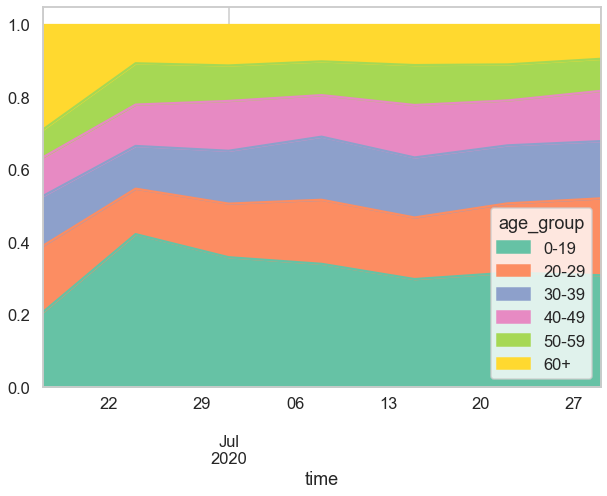

In [286]:
sns.set_style('whitegrid')
sns.set_context('talk')

rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [287]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='datagov_archive', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

first_week_day last_week_day age_group   gender weekly_tests_num  \
0     2020-03-15    2020-03-21      0-19      זכר           1083.0   
1     2020-03-15    2020-03-21      0-19     נקבה            894.0   
2     2020-03-15    2020-03-21      0-19  לא ידוע             31.0   
3     2020-03-15    2020-03-21     20-24     נקבה            620.0   
4     2020-03-15    2020-03-21     20-24      זכר            695.0   

  weekly_newly_tested weekly_cases weekly_deceased  
0              1032.0         36.0             0.0  
1               857.0         39.0             0.0  
2                31.0          0.0             0.0  
3               601.0         34.0             0.0  
4               650.0        105.0             0.0

In [288]:
ag.weekly_deceased.value_counts()

0.0     1276
<15      383
27.0       4
15.0       4
20.0       4
22.0       3
26.0       3
18.0       3
33.0       2
19.0       2
16.0       2
17.0       2
34.0       2
23.0       2
51.0       1
29.0       1
47.0       1
46.0       1
63.0       1
70.0       1
25.0       1
76.0       1
31.0       1
74.0       1
52.0       1
39.0       1
55.0       1
66.0       1
21.0       1
60.0       1
32.0       1
35.0       1
Name: weekly_deceased, dtype: int64

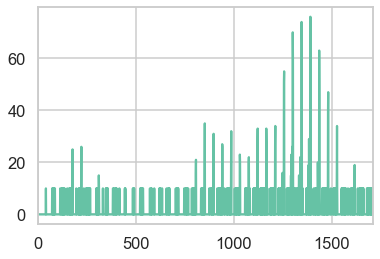

In [289]:
ag.weekly_deceased.replace('<15','10').astype(float).astype(int).plot()

## Dashboard Data

In [290]:
dash_folder = 'dashboard_data'
city_file_name = 'contagionDataPerCityPublic.csv'

In [291]:
city_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            city_path = os.path.join(tfolder, city_file_name)
            if os.path.isdir(tfolder) and os.path.exists(city_path):
                city_df = city_df.append(pd.read_csv(city_path), sort=False)
                
city_df['date'] = pd.to_datetime(city_df.date)
city_df.head()

city sickCount actualSick verifiedLast7Days  testLast7Days  \
0        ירושלים     16214       3748              1266          13868   
1        בני ברק      9144       1252               482           3043   
2  מודיעין עילית      3122       1085               475           2004   
3            רהט       780        240               118            792   
4       כפר קאסם       455        185               109            501   

   patientDiffPopulationForTenThousands                             status  \
0                                    40  נדרשים הסברה, בדיקות ואכיפת בידוד   
1                                    62  נדרשים הסברה, בדיקות ואכיפת בידוד   
2                                   141  נדרשים הסברה, בדיקות ואכיפת בידוד   
3                                    36  נדרשים הסברה, בדיקות ואכיפת בידוד   
4                                    77  נדרשים הסברה, בדיקות ואכיפת בידוד   

                 lastUpdate                             date  
0  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
1  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
2  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
3  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
4  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00

In [292]:
city_df.dtypes

city                                                 object
sickCount                                            object
actualSick                                           object
verifiedLast7Days                                    object
testLast7Days                                         int64
patientDiffPopulationForTenThousands                  int64
status                                               object
lastUpdate                                           object
date                                    datetime64[ns, UTC]
dtype: object

In [293]:
city_tests = (city_df
              .groupby([pd.Grouper(key='date', freq='1d'), 'city'])['testLast7Days', 'verifiedLast7Days'].max()
              .assign(positive_rate = lambda x: x.verifiedLast7Days.str.strip().replace('<15', '8').replace('1-5', '3').replace('6-10', '8').replace('11-14', '13').astype(int) / x.testLast7Days)
              .reset_index())
city_tests.head()

date                city  testLast7Days  \
0 2020-08-19 00:00:00+00:00  אבו ג'ווייעד (שבט)             12   
1 2020-08-19 00:00:00+00:00             אבו גוש            256   
2 2020-08-19 00:00:00+00:00            אבו סנאן            399   
3 2020-08-19 00:00:00+00:00   אבו קורינאת (שבט)             13   
4 2020-08-19 00:00:00+00:00   אבו רובייעה (שבט)             20   

  verifiedLast7Days  positive_rate  
0                 0       0.000000  
1                24       0.093750  
2                18       0.045113  
3                 0       0.000000  
4                 0       0.000000

In [294]:
#top_cities = city_tests.groupby('city').testLast7Days.mean().sort_values(ascending=False)[:20].index
from datetime import date, timedelta
yesterday = city_tests.date.max() - timedelta(days=1)
top_cities = city_tests[city_tests.date==yesterday].sort_values(by='testLast7Days', ascending=False).head(20).city

In [295]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='testLast7Days',
    size=alt.Size('positive_rate:Q', bin={'steps':[0.02,0.05,0.1]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [296]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).transform_joinaggregate(
     groupby = ['date'], TotalTests='sum(testLast7Days)',
).transform_calculate(
    PercentTests="datum.testLast7Days / datum.TotalTests"
).mark_area().encode(
    x='date',
    y='PercentTests:Q',
    color='city',
    #size='mean(positive_rate)',
    tooltip=['date', 'city', 'PercentTests:Q']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [297]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='positive_rate',
    size=alt.Size('testLast7Days', bin={'steps':[1000,2000,5000,10000]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [298]:
ct_change = (city_tests[city_tests.date.isin(['2020-08-31',yesterday.strftime('%Y-%m-%d') ])]
 .assign(date = lambda x: x.date.dt.strftime('%Y-%m-%d'))            
 .pivot(index='city', columns='date')[['testLast7Days', 'positive_rate']]
 .assign(test_ratio=lambda x: (x.iloc[:, 1]/x.iloc[:,0]).round(2))
 .assign(pr_ratio=lambda x: (x.iloc[:, 3]/x.iloc[:,2]).round(2))
 .assign(positive_rate = lambda x: x.positive_rate.round(2))
 .sort_values(by='test_ratio', ascending=False)
 
 )
ct_change[ct_change[('testLast7Days', yesterday.strftime('%Y-%m-%d'))]>=300].head(30)#.loc[list(top_cities), :]


testLast7Days            positive_rate            test_ratio  \
date             2020-08-31 2020-12-12    2020-08-31 2020-12-12              
city                                                                         
מסעדה                    18        571          0.17       0.09      31.72   
אילת                    520      11018          0.05       0.00      21.19   
קדומים                   52        979          0.06       0.01      18.83   
בית חשמונאי              17        301          0.00       0.03      17.71   
גבעת שמואל              302       5094          0.07       0.00      16.87   
ג'ש (גוש חלב)            35        469          0.09       0.01      13.40   
עלי זהב                  32        421          0.09       0.01      13.16   
שמשית                    25        310          0.12       0.01      12.40   
נווה דניאל               27        301          0.00       0.03      11.15   
מג'דל שמס               103       1113          0.08       0.12      10.81   
אלון שבות                54        581          0.00       0.02      10.76   
צור יצחק                 72        774          0.04       0.00      10.75   
רבבה                     35        306          0.00       0.01       8.74   
עין נקובא                63        549          0.05       0.06       8.71   
טלמון                    44        380          0.00       0.01       8.64   
יד בנימין                56        471          0.14       0.03       8.41   
עלי                      39        325          0.08       0.01       8.33   
ערד                     346       2812          0.02       0.00       8.13   
מצפה רמון                39        316          0.08       0.01       8.10   
רמת ישי                  88        684          0.03       0.00       7.77   
חשמונאים                 49        371          0.06       0.01       7.57   
להבים                   107        785          0.03       0.01       7.34   
ירוחם                   116        840          0.03       0.00       7.24   
אפרת                    174       1253          0.07       0.00       7.20   
מעלות-תרשיחא            367       2542          0.04       0.02       6.93   
עיילבון                  94        646          0.09       0.01       6.87   
כפר אדומים               64        429          0.05       0.02       6.70   
אלקנה                    56        367          0.05       0.01       6.55   
צור הדסה                157        998          0.02       0.01       6.36   
כפר ורדים                71        447          0.04       0.02       6.30   

              pr_ratio  
date                    
city                    
מסעדה             0.57  
אילת              0.02  
קדומים            0.14  
בית חשמונאי        inf  
גבעת שמואל        0.06  
ג'ש (גוש חלב)     0.07  
עלי זהב           0.08  
שמשית             0.08  
נווה דניאל         inf  
מג'דל שמס         1.58  
אלון שבות          inf  
צור יצחק          0.09  
רבבה               inf  
עין נקובא         1.34  
טלמון              inf  
יד בנימין         0.19  
עלי               0.12  
ערד               0.20  
מצפה רמון         0.12  
רמת ישי           0.13  
חשמונאים          0.13  
להבים             0.36  
ירוחם             0.14  
אפרת              0.03  
מעלות-תרשיחא      0.56  
עיילבון           0.15  
כפר אדומים        0.40  
אלקנה             0.15  
צור הדסה          0.68  
כפר ורדים         0.42

C:\Users\dbare\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


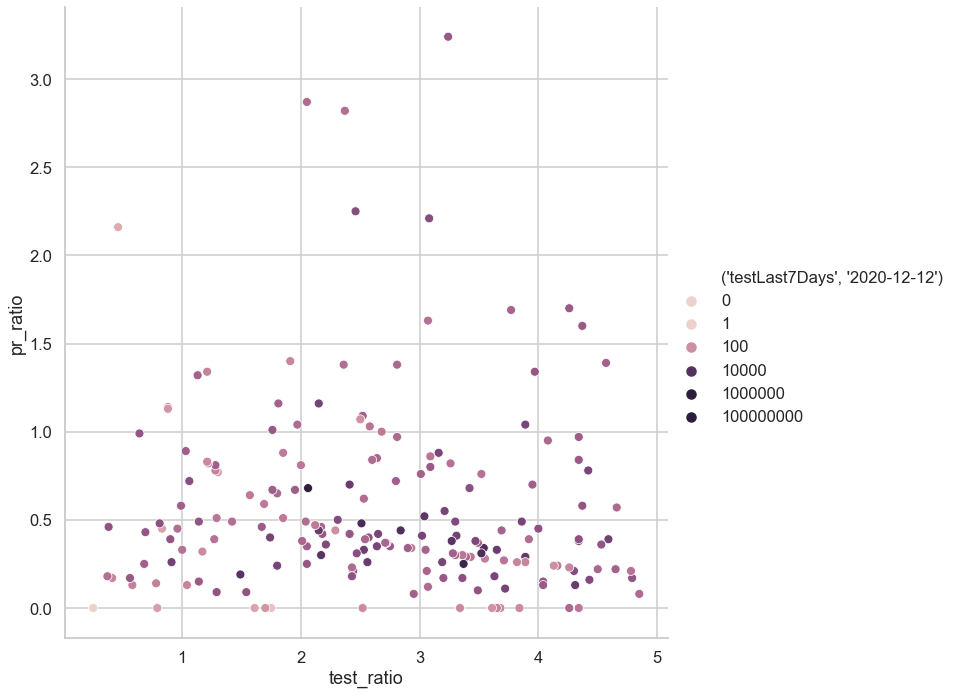

In [299]:
from matplotlib.colors import LogNorm

sns.relplot(data=ct_change[(ct_change.test_ratio<5) & (ct_change.pr_ratio<4)], x='test_ratio', y='pr_ratio', 
            hue=('testLast7Days', yesterday.strftime('%Y-%m-%d')), hue_norm=LogNorm(),
            height=10)

In [300]:
tr_file_name = 'testResultsPerDate.csv'

In [301]:
tr_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            tr_path = os.path.join(tfolder, tr_file_name)
            if os.path.isdir(tfolder) and os.path.exists(tr_path):
                tr_df = tr_df.append(pd.read_csv(tr_path), sort=False)
                
tr_df['date'] = pd.to_datetime(tr_df.date)
tr_df.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
316 2020-12-09 00:00:00+00:00   75205                 73633            1863   
317 2020-12-10 00:00:00+00:00   77472                 76021            1994   
318 2020-12-11 00:00:00+00:00   77191                 75671            1824   
319 2020-12-12 00:00:00+00:00   44853                 43992            1291   
320 2020-12-13 00:00:00+00:00   24527                 24073             917   

                   lastUpdate  amountMagen  
316  2020-12-13T16:21:49.793Z      12637.0  
317  2020-12-13T16:21:49.793Z       9935.0  
318  2020-12-13T16:21:49.793Z      10611.0  
319  2020-12-13T16:21:49.793Z       3631.0  
320  2020-12-13T16:21:49.793Z        269.0

In [302]:
tr_df.dtypes

date                    datetime64[ns, UTC]
amount                                int64
amountVirusDiagnosis                  int64
positiveAmount                        int64
lastUpdate                           object
amountMagen                         float64
dtype: object

In [303]:
tr = (tr_df.sort_values('lastUpdate', ascending=False)
              .groupby(['date']).head(1)
              .sort_values('date')
     .assign(positive_rate = lambda x: x.positiveAmount/x.amountVirusDiagnosis))
tr.tail(20)

date  amount  amountVirusDiagnosis  positiveAmount  \
301 2020-11-24 00:00:00+00:00   60000                 58727             857   
302 2020-11-25 00:00:00+00:00   61037                 59641            1079   
303 2020-11-26 00:00:00+00:00   54563                 53377            1087   
304 2020-11-27 00:00:00+00:00   48852                 47971            1032   
305 2020-11-28 00:00:00+00:00   17528                 17182             581   
306 2020-11-29 00:00:00+00:00   40458                 39519            1025   
307 2020-11-30 00:00:00+00:00   58845                 57529            1258   
308 2020-12-01 00:00:00+00:00   65292                 63977            1199   
309 2020-12-02 00:00:00+00:00   72828                 71282            1587   
310 2020-12-03 00:00:00+00:00   65455                 64145            1451   
311 2020-12-04 00:00:00+00:00   61636                 60401            1516   
312 2020-12-05 00:00:00+00:00   25868                 25363            1000   
313 2020-12-06 00:00:00+00:00   42915                 42053            1364   
314 2020-12-07 00:00:00+00:00   67612                 66039            1860   
315 2020-12-08 00:00:00+00:00   70411                 69078            1764   
316 2020-12-09 00:00:00+00:00   75205                 73633            1863   
317 2020-12-10 00:00:00+00:00   77472                 76021            1994   
318 2020-12-11 00:00:00+00:00   77191                 75671            1824   
319 2020-12-12 00:00:00+00:00   44853                 43992            1291   
320 2020-12-13 00:00:00+00:00   24527                 24073             917   

                   lastUpdate  amountMagen  positive_rate  
301  2020-12-13T16:21:49.793Z      14636.0       0.014593  
302  2020-12-13T16:21:49.793Z      12893.0       0.018092  
303  2020-12-13T16:21:49.793Z       6395.0       0.020365  
304  2020-12-13T16:21:49.793Z       5989.0       0.021513  
305  2020-12-13T16:21:49.793Z       3149.0       0.033814  
306  2020-12-13T16:21:49.793Z       3200.0       0.025937  
307  2020-12-13T16:21:49.793Z      10458.0       0.021867  
308  2020-12-13T16:21:49.793Z      15380.0       0.018741  
309  2020-12-13T16:21:49.793Z      13544.0       0.022264  
310  2020-12-13T16:21:49.793Z      11444.0       0.022621  
311  2020-12-13T16:21:49.793Z       8326.0       0.025099  
312  2020-12-13T16:21:49.793Z       1602.0       0.039428  
313  2020-12-13T16:21:49.793Z       1843.0       0.032435  
314  2020-12-13T16:21:49.793Z       9318.0       0.028165  
315  2020-12-13T16:21:49.793Z      10784.0       0.025536  
316  2020-12-13T16:21:49.793Z      12637.0       0.025301  
317  2020-12-13T16:21:49.793Z       9935.0       0.026230  
318  2020-12-13T16:21:49.793Z      10611.0       0.024104  
319  2020-12-13T16:21:49.793Z       3631.0       0.029346  
320  2020-12-13T16:21:49.793Z        269.0       0.038092